In [1]:
from hlm_basic.ssn import GenerateNetwork, UpstreamArea
from hlm_basic.watershed import Watershed
from hlm_basic.tools import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
from fitness_scenarios import *
import pickle

## Using hourly rainfall data of a rain gauge (USCRN), simulations are run to sample initial conditions from simulations 

In [2]:
# Properties of artificial watershed
l_id, connectivity, h_order, nextlink = GenerateNetwork(5)
n_hills = len(connectivity)
a_hill = 0.5 * 0.5 #km2
A_h = np.array([a_hill*10**6 for i in range(n_hills)]) #m2
L_i = np.array([0.5*10**3 for i in range(n_hills)])  #m
A_i = UpstreamArea(a_hill, connectivity, h_order) #km2

In [3]:
forcing, raw_data, cum_forcing = GetForcing("../data/rainfall/2010_timeseries.csv", '2010-01-01','2010-12-31', cumulative=True)
te = len(forcing)-1

In [4]:
SSN1 = Watershed(Model=254)
SSN1.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)

columns = SSN1.__columns__()
dc_nodam = pd.DataFrame(columns =columns[0])
IC = {}
t0 = 0
step = 500 # snapshots will be taken every 500 mins
while t0 < te-step:
    if t0 == 0:
        q, s_p, s_t, s_s = Set_InitialConditions(1.5, A_i[0], A_i)
    else:
        q, s_p, s_t, s_s = SSN1.Get_Snapshot()
        if t0 >= 24000:
                ic = {'q':q, 's_p':s_p,'s_t':s_t,'s_s':s_s}
                IC[t0] = ic

    #define initial conditions
    SSN1.initialize(q=q, s_p=s_p,s_t =s_t, s_s=s_s)

    dc = SSN1.Run_254( [t0, t0+step],forcing, rtol=1e-6,)
    
    dc_nodam = dc_nodam.append(dc)
    t0 += step
#save snaphots    
with open(f'../data/initial_conditions.pickle', 'wb') as f:
    pickle.dump(IC, f)

Model 254 is being used!
524000

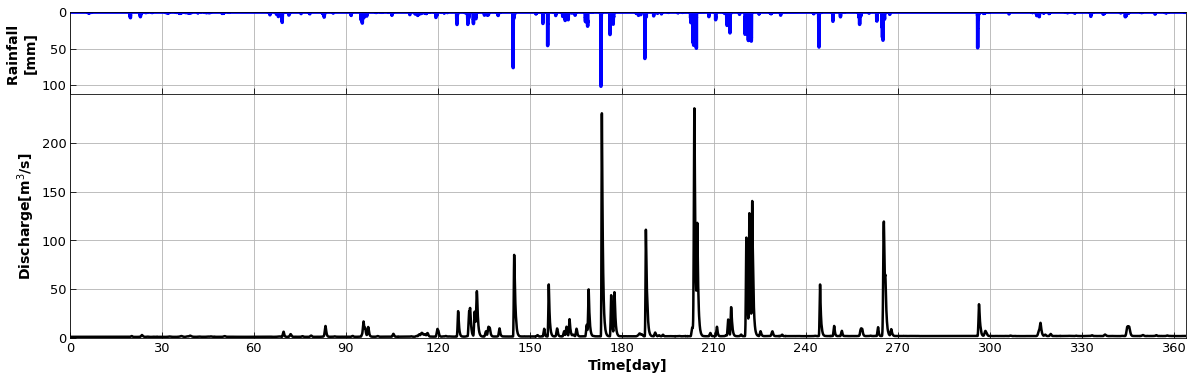

In [6]:
pltkwargs = np.array([{'label':'No Dam', 'color':'k','linewidth':2.5}])
pltKwargs = pltkwargs[[0]]
dataset = [dc_nodam]
plot_sim(0, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,250,50],
         x_timescale='day', x_stepsize=30, legend=False, save='../data/figures/2010_timeseries_hydrograph.png')